# MSiA 432 - Deep Learning - Final Project
# Group #: Alejandra Lelo de Larrea Ibarra, Bannasorn Paspanthong, Ruben Nakano, Samuel Swain
# Data Augmentation

Geometric Transformation: translation, rotation, reflection, flipping, zoomming, scaling, cropping, padding, perspective transformation, elastic distortion, lens distortion, mirroring, etc.

Photometric Transformation: color jittering, grayscaling, filtering, lighting perturbation, noise adding, vignetting, contrast adjustment, random erasing, etc.

# Libraries

In [29]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import shutil
from PIL import Image

import cv2
import albumentations as A

#### Set path to dataset folder

In [10]:
path = '../02_Data/face_age/'

#### Create example of augmentations. We can choose which ones we want to apply and select the parameters using this: https://demo.albumentations.ai

In [12]:
# Load the image from URL
img = cv2.imread(path+'001/18.png')

# Convert it from BGR to RGB (https://albumentations.ai/docs/examples/example/)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Define augmentations
crop_transform = A.RandomCrop(width=150, height=150)
hflip_transform = A.HorizontalFlip(p=1)
vflip_transform = A.VerticalFlip(p=1)
rotate_transform = A.Rotate(limit=30, p=1)
blur_transform = A.Blur(blur_limit=3, p=1)
noise_transform = A.GaussNoise(var_limit=(100.0, 500.0), p=1)
brightness_transform = A.RandomBrightnessContrast(p=1)
hue_transform = A.HueSaturationValue(p=1)
clahe_transform = A.CLAHE(p=1)
elastic_transform = A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1)
grid_distortion_transform = A.GridDistortion(p=1)
optical_distortion_transform = A.OpticalDistortion(distort_limit=2, p=1)

# Apply augmentations to image
crop_img = crop_transform(image=img)['image']
hflip_img = hflip_transform(image=img)['image']
vflip_img = vflip_transform(image=img)['image']
rotate_img = rotate_transform(image=img)['image']
blur_img = blur_transform(image=img)['image']
noise_img = noise_transform(image=img)['image']
brightness_img = brightness_transform(image=img)['image']
hue_img = hue_transform(image=img)['image']
clahe_img = clahe_transform(image=img)['image']
elastic_img = elastic_transform(image=img)['image']
grid_distortion_img = grid_distortion_transform(image=img)['image']
optical_distortion_img = optical_distortion_transform(image=img)['image']

Text(0.5, 1.0, 'Grid Distortion')

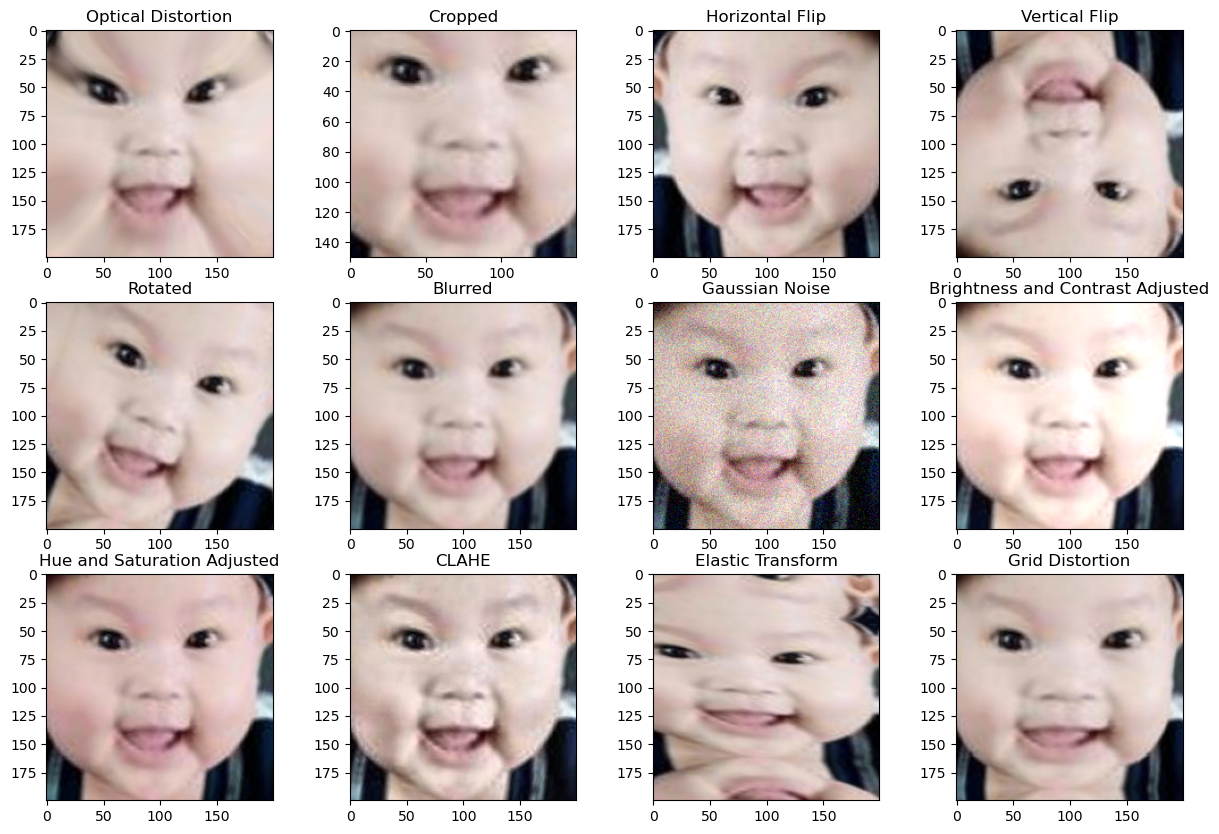

In [13]:
# Plot augmented images
fig, axes = plt.subplots(3, 4, figsize=(15, 10))

axes[0, 0].imshow(optical_distortion_img)
axes[0, 0].set_title("Optical Distortion")

axes[0, 1].imshow(crop_img)
axes[0, 1].set_title("Cropped")

axes[0, 2].imshow(hflip_img)
axes[0, 2].set_title("Horizontal Flip")

axes[0, 3].imshow(vflip_img)
axes[0, 3].set_title("Vertical Flip")

axes[1, 0].imshow(rotate_img)
axes[1, 0].set_title("Rotated")

axes[1, 1].imshow(blur_img)
axes[1, 1].set_title("Blurred")

axes[1, 2].imshow(noise_img)
axes[1, 2].set_title("Gaussian Noise")

axes[1, 3].imshow(brightness_img)
axes[1, 3].set_title("Brightness and Contrast Adjusted")

axes[2, 0].imshow(hue_img)
axes[2, 0].set_title("Hue and Saturation Adjusted")

axes[2, 1].imshow(clahe_img)
axes[2, 1].set_title("CLAHE")

axes[2, 2].imshow(elastic_img)
axes[2, 2].set_title("Elastic Transform")

axes[2, 3].imshow(grid_distortion_img)
axes[2, 3].set_title("Grid Distortion")

#### Fix data imbalance
First need to count data in each age group

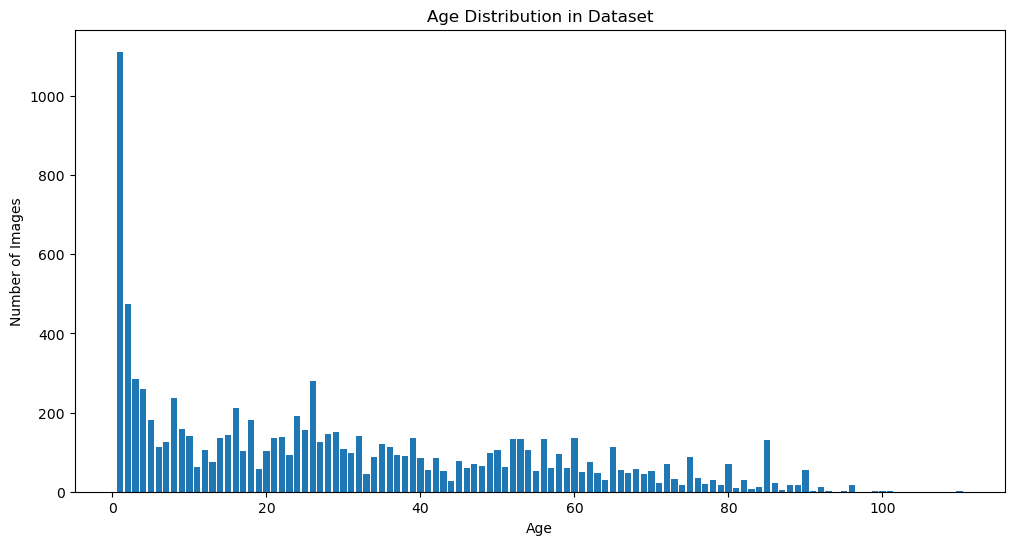

In [14]:
# Count the number of images per age
age_counts = []
for age_folder in os.listdir(path):
    if age_folder != '.DS_Store':
        age = int(age_folder)
        age_count = len(os.listdir(os.path.join(path, age_folder)))
        age_counts.append((age, age_count))

# Create a DataFrame and sort by age
age_df = pd.DataFrame(age_counts, columns=['age', 'count'])
age_df = age_df.sort_values('age')

# Plot the age distribution
plt.figure(figsize=(12, 6))
plt.bar(age_df['age'], age_df['count'])
plt.xlabel('Age')
plt.ylabel('Number of Images')
plt.title('Age Distribution in Dataset')
plt.show()

In [23]:
def num_augmentation(df, duplicate_age1:int=1):
    
    # number of image needed for each age section
    num_need = int(df[df['age'] == 1]['count'].iloc[0]) * duplicate_age1
    
    # make dictionary of key (age) and value (how many new image needed)
    num_augment = dict()
    for age in df['age']:
        num_augment[age] = num_need - int(df[df['age'] == age]['count'].iloc[0])
        
    return num_augment

This code will generate new folder in 02_Data/face_age folder that will only consist of augmented data (around 11% should be just plain duplicated image). 

In [36]:
# Define the augmentations you want to apply
# this settings, 11% chance of having no transformation

num_augment = num_augmentation(age_df)

transform = A.Compose([
    A.HorizontalFlip(p=0.1),
    A.VerticalFlip(p=0.05),
    A.Rotate(limit=30, p=0.15),
    A.RandomBrightnessContrast(p=0.4),
    A.GaussianBlur(blur_limit=3, p=0.4),
    A.HueSaturationValue(p=0.35),
    A.GaussNoise(var_limit=(100.0, 500.0), p=0.2),
    A.CLAHE(p=0.2)
])

new_folder = os.path.join(path, "augmented_data")

# check if augmented_data folder exists (delete if exists)
if os.path.exists(new_folder):
    shutil.rmtree(new_folder)


# Loop through each subfolder in the path
for folder_name in os.listdir(path):
    # Skip any non-folder files
    if not os.path.isdir(os.path.join(path, folder_name)):
        continue
    
    # get age of that folder
    target_age = int(folder_name)
    
    # Define the folder path and create a new folder for the augmented images
    folder_path = os.path.join(path, folder_name)
    new_folder_path = os.path.join(new_folder, f"aug_{folder_name}")
    os.makedirs(new_folder_path, exist_ok=True)
    
    ## Loop through each image in the folder
    
    # loop throught the entire folder floor(total_image_need / total_image_have)
    for i in range(num_augment[target_age] // int(age_df[age_df['age'] == target_age]['count'].iloc[0])):   
        for image_name in os.listdir(folder_path):
            # Load the image
            image_path = os.path.join(folder_path, image_name)
            image = cv2.imread(image_path)
            
            # Apply the augmentations to the image
            augmented = transform(image=image)
            augmented_image = augmented["image"]
            
            # Save the augmented image to the new folder
            new_image_path = os.path.join(new_folder_path, f"aug_{image_name}_{i}")
            cv2.imwrite(new_image_path, augmented_image)
    
    # randomly augment remaining (total_image_need % total_image_have) image to have the same number
    remaining_img = num_augment[target_age] % int(age_df[age_df['age'] == target_age]['count'].iloc[0])
    count = 0
    for image_name in os.listdir(folder_path):
        
        if count >= remaining_img:
            break
        
        # Load the image
        image_path = os.path.join(folder_path, image_name)
        image = cv2.imread(image_path)
        
        # Apply the augmentations to the image
        augmented = transform(image=image)
        augmented_image = augmented["image"]
        
        # Save the augmented image to the new folder
        new_image_path = os.path.join(new_folder_path, f"aug_{image_name}_r")
        cv2.imwrite(new_image_path, augmented_image)
        count += 1


/opt/homebrew/Caskroom/miniconda/base/envs/DL2/lib/python3.10/site-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(
